In [1]:
import numpy as np
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
import math

# Import Foot data and compute the measurement series

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML
adhd1 = pd.read_csv("data/TAIWAN_RAW_DATA/ADHD/A2_886001_20170227_184017/A2FootSensor_886001_20170227_184017.csv") # has no hands and feet data
adhd2 = pd.read_csv("data/TAIWAN_RAW_DATA/ADHD/A2_886002_20170228_104813/A2FootSensor_886002_20170228_104813.csv")#has not hands and feet data
adhd3 = pd.read_csv("data/TAIWAN_RAW_DATA/ADHD/A2_886006_20170304_172008/A2FootSensor_886006_20170304_172008.csv")
adhd4 = pd.read_csv("data/TAIWAN_RAW_DATA/ADHD/A2_886010_20170305_132607/A2FootSensor_886010_20170305_132607.csv")
adhd5 = pd.read_csv("data/TAIWAN_RAW_DATA/ADHD/A2_886015_20170311_153739/A2FootSensor_886015_20170311_153739.csv")
adhd6 = pd.read_csv("data/TAIWAN_RAW_DATA/ADHD/A2_886016_20170311_184832/A2FootSensor_886016_20170311_184832.csv")
adhd7 = pd.read_csv("data/TAIWAN_RAW_DATA/ADHD/A2_886017_20170312_112519/A2FootSensor_886017_20170312_112519.csv")
adhd8 = pd.read_csv("data/TAIWAN_RAW_DATA/ADHD/A2_886018_20170317_192755/A2FootSensor_886018_20170317_192755.csv")
adhd9 = pd.read_csv("data/TAIWAN_RAW_DATA/ADHD/A2_886019_20170318_130057/A2FootSensor_886019_20170318_130057.csv")
adhd10 =  pd.read_csv("data/TAIWAN_RAW_DATA/ADHD/A2_886020_20170318_135002/A2FootSensor_886020_20170318_135002.csv")
healthy1 = pd.read_csv("data/TAIWAN_RAW_DATA/HEALTHY/A2_886003_20170228_130925/A2FootSensor_886003_20170228_130925.csv")
healthy2 = pd.read_csv("data/TAIWAN_RAW_DATA/HEALTHY/A2_886004_20170304_152912/A2FootSensor_886004_20170304_152912.csv")
healthy3 = pd.read_csv("data/TAIWAN_RAW_DATA/HEALTHY/A2_886005_20170304_160532/A2FootSensor_886005_20170304_160532.csv")
healthy4 = pd.read_csv("data/TAIWAN_RAW_DATA/HEALTHY/A2_886007_20170305_102310/A2FootSensor_886007_20170305_102310.csv")
healthy5 = pd.read_csv("data/TAIWAN_RAW_DATA/HEALTHY/A2_886008_20170305_105348/A2FootSensor_886008_20170305_105348.csv")
healthy6 = pd.read_csv("data/TAIWAN_RAW_DATA/HEALTHY/A2_886009_20170305_112726/A2FootSensor_886009_20170305_112726.csv")
healthy7 = pd.read_csv("data/TAIWAN_RAW_DATA/HEALTHY/A2_886011_20170309_190528/A2FootSensor_886011_20170309_190528.csv")
healthy8 = pd.read_csv("data/TAIWAN_RAW_DATA/HEALTHY/A2_886012_20170309_193106/A2FootSensor_886012_20170309_193106.csv")
healthy9 = pd.read_csv("data/TAIWAN_RAW_DATA/HEALTHY/A2_886013_20170309_200214/A2FootSensor_886013_20170309_200214.csv")
healthy10 = pd.read_csv("data/TAIWAN_RAW_DATA/HEALTHY/A2_886014_20170309_205449/A2FootSensor_886014_20170309_205449.csv")

ADHD = [adhd8, adhd9, adhd10]
HEALTHY = []
#HEALTHY = [healthy2, healthy3, healthy4, healthy5, healthy6, healthy7, healthy8, healthy9, healthy10]
numofADHD = 5
numofHEALTHY = 9

# Calculate Pitch and Roll from Accelerometer for Every Kid

In [3]:
#Create two lists that stores the info we need for kalman filter(roll_rate, pitch_rate, roll, pitch, roll_rate_iter, pitch_rate_iter)
A = []
H = []
RAD_TO_DEG = 180 / math.pi

def calculate_angle(HEALTHYorADHD, AorH):
    for item in HEALTHYorADHD:
        roll_rate = item['Roll']
        pitch_rate = item['Pitch']
        roll  = [math.atan2(item['Ay'][i], item['Az'][i]) * RAD_TO_DEG for i in range(len(item['Ay']))];
        pitch = [math.atan((-item['Ax'][i]) / (math.sqrt(item['Ay'][i] * item['Ay'][i] + item['Az'][i] * item['Az'][i]) + 0.00001)) * RAD_TO_DEG for i in range(len(item['Ay']))];
        roll_rate_iter = iter(roll_rate)
        pitch_rate_iter = iter(pitch_rate)
        roll_iter = iter(roll)
        pitch_iter = iter(pitch)
        package = [roll_rate, pitch_rate, roll, pitch, roll_rate_iter, pitch_rate_iter, roll_iter, pitch_iter]
        AorH.append(package)
    assert(len(AorH) == len(HEALTHYorADHD))

calculate_angle(HEALTHY, H)
calculate_angle(ADHD, A)

# Constants for Kalman Filter

In [4]:

Q_angle = 0.001
Q_gyroBias = 0.003
R_measure = 0.03
dt = 0.05



# Filter!

In [5]:
def kalman(AorH, ROLLorPITCH): #0 for roll, pitch for 1
    for item in AorH:
        f = KalmanFilter(dim_x=2, dim_z=1, dim_u=1)
        f.x = np.array([[item[2 + ROLLorPITCH][0]],
                        [0.]])       # initial state

        f.F = np.array([[1.,-dt],
                        [0.,1.]])    # state transition matrix

        f.H = np.array([[1.,0.]])    # Measurement function
        f.P *= 1000.                 # covariance matrix
        f.R = R_measure                     # state uncertainty
        f.Q = np.array([[Q_angle, 0.],
                        [0., Q_gyroBias]])  # process uncertainty
        f.B = np.array([[dt],
                [0.]])
        filtered = [f.x[0][0]] # store the data after filtering
        try:
            while True:
                f.predict(u = next(item[4 + ROLLorPITCH])) #predict with gyroscope measurement
                f.update(next(item[6 + ROLLorPITCH])) #update with accelerometer measurement
                filtered.append(f.x[0][0])
        except StopIteration:
            item.append(filtered)

kalman(A, 0)
kalman(A, 1)
kalman(H, 0)
kalman(H, 1)

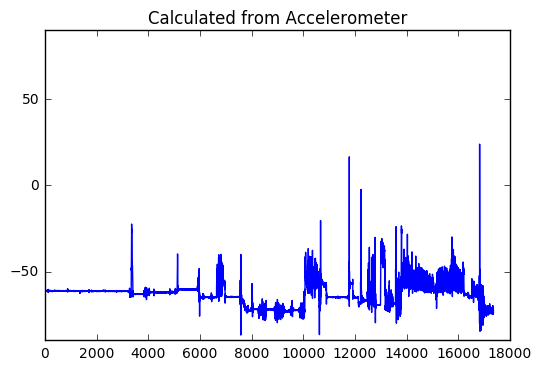

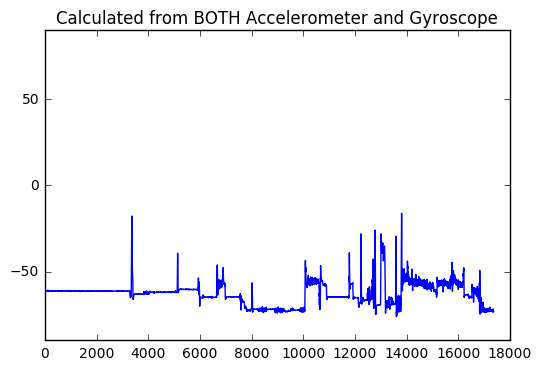

In [45]:
fig = plt.figure()
plt.plot(A[1][3])
plt.title("Calculated from Accelerometer")
plt.ylim(-90, 90)
plt.show()
fig = plt.figure()
plt.plot(A[1][9])
plt.title("Calculated from BOTH Accelerometer and Gyroscope")
plt.ylim(-90, 90)
plt.show()

In [6]:
def fix_180_90(AorH):
    for subject in AorH:
        for i in range(len(subject[8])):
            if (subject[8][i] > 180):
                subject[8][i] = 180
            elif (subject[8][i] < -180):
                subject[8][i] = -180
        for i in range(len(subject[9])):
            if (subject[9][i] > 90):
                subject[9][i] = 90
            elif (subject[9][i] < -90):
                subject[9][i] = -90
        
fix_180_90(A)
fix_180_90(H)

# Gravity Compensation with Row and Pitch Calculated

In [7]:


def compensate(ADHDorHEALTHY, AorH):
    for i in range(len(AorH)):
        x = [-math.sin(theta / RAD_TO_DEG) for theta in AorH[i][9]] #theta is 9, phi is 8
        y = [math.cos(AorH[i][9][j] / RAD_TO_DEG) * math.sin(AorH[i][8][j] / RAD_TO_DEG) for j in range(len(AorH[i][9]))]
        z = [math.cos(AorH[i][9][j] / RAD_TO_DEG) * math.cos(AorH[i][8][j] / RAD_TO_DEG) for j in range(len(AorH[i][9]))]
        ADHDorHEALTHY[i]['Ax'] = np.subtract(x[:-1], ADHDorHEALTHY[i]['Ax'])
        ADHDorHEALTHY[i]['Ay'] = np.subtract(y[:-1], ADHDorHEALTHY[i]['Ay'])
        ADHDorHEALTHY[i]['Az'] = np.subtract(z[:-1], ADHDorHEALTHY[i]['Az'])
        
compensate(ADHD, A)
compensate(HEALTHY, H)

# adhd1.to_csv("data/TAIWAN_RAW_DATA/ADHD/A2_886001_20170227_184017/gcompensated_A2FootSensor_886001_20170227_184017.csv")
# adhd2.to_csv("data/TAIWAN_RAW_DATA/ADHD/A2_886002_20170228_104813/gcompensated_A2FootSensor_886002_20170228_104813.csv")#has not hands and feet data
# adhd3.to_csv("data/TAIWAN_RAW_DATA/ADHD/A2_886006_20170304_172008/gcompensated_A2FootSensor_886006_20170304_172008.csv")
# adhd4.to_csv("data/TAIWAN_RAW_DATA/ADHD/A2_886010_20170305_132607/gcompensated_A2FootSensor_886010_20170305_132607.csv")
# adhd5.to_csv("data/TAIWAN_RAW_DATA/ADHD/A2_886015_20170311_153739/gcompensated_A2FootSensor_886015_20170311_153739.csv")
# adhd6.to_csv("data/TAIWAN_RAW_DATA/ADHD/A2_886016_20170311_184832/gcompensated_A2FootSensor_886016_20170311_184832.csv")
# adhd7.to_csv("data/TAIWAN_RAW_DATA/ADHD/A2_886017_20170312_112519/gcompensated_A2FootSensor_886017_20170312_112519.csv")
adhd8.to_csv("data/TAIWAN_RAW_DATA/ADHD/A2_886018_20170317_192755/gcompensated_A2FootSensor_886018_20170317_192755.csv")
adhd9.to_csv("data/TAIWAN_RAW_DATA/ADHD/A2_886019_20170318_130057/gcompensated_A2FootSensor_886019_20170318_130057.csv")
adhd10.to_csv("data/TAIWAN_RAW_DATA/ADHD/A2_886020_20170318_135002/gcompensated_A2FootSensor_886020_20170318_135002.csv")
# healthy1.to_csv("data/TAIWAN_RAW_DATA/HEALTHY/A2_886003_20170228_130925/gcompensated_A2FootSensor_886003_20170228_130925.csv")
# healthy2.to_csv("data/TAIWAN_RAW_DATA/HEALTHY/A2_886004_20170304_152912/gcompensated_A2FootSensor_886004_20170304_152912.csv")
# healthy3.to_csv("data/TAIWAN_RAW_DATA/HEALTHY/A2_886005_20170304_160532/gcompensated_A2FootSensor_886005_20170304_160532.csv")
# healthy4.to_csv("data/TAIWAN_RAW_DATA/HEALTHY/A2_886007_20170305_102310/gcompensated_A2FootSensor_886007_20170305_102310.csv")
# healthy5.to_csv("data/TAIWAN_RAW_DATA/HEALTHY/A2_886008_20170305_105348/gcompensated_A2FootSensor_886008_20170305_105348.csv")
# healthy6.to_csv("data/TAIWAN_RAW_DATA/HEALTHY/A2_886009_20170305_112726/gcompensated_A2FootSensor_886009_20170305_112726.csv")
# healthy7.to_csv("data/TAIWAN_RAW_DATA/HEALTHY/A2_886011_20170309_190528/gcompensated_A2FootSensor_886011_20170309_190528.csv")
# healthy8.to_csv("data/TAIWAN_RAW_DATA/HEALTHY/A2_886012_20170309_193106/gcompensated_A2FootSensor_886012_20170309_193106.csv")
# healthy9.to_csv("data/TAIWAN_RAW_DATA/HEALTHY/A2_886013_20170309_200214/gcompensated_A2FootSensor_886013_20170309_200214.csv")
# healthy10.to_csv("data/TAIWAN_RAW_DATA/HEALTHY/A2_886014_20170309_205449/gcompensated_A2FootSensor_886014_20170309_205449.csv")
